# **Dataset Analysis**

In this file, we analyze the dataset to determine if the task is ill-defined.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

Taking only numerical features used for classification

In [3]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

Reconstruct the dataset

In [4]:
train_data["top_20"] = train_labels["top_20"]
test_data["top_20"] = test_labels["top_20"]

races_df = pd.concat([train_data, test_data], ignore_index=True)

races_df.head()

,climb_total,cyclist_age,cyclist_level,cyclist_experience,avg_relative_position,position_entropy,top_20_entropy,top_20
0,0.008,24.0,181.264339,5,0.274943,2.321928,0.970951,0
1,2.462,23.0,83.920998,3,0.650329,1.584963,0.000000,0
2,2.917,31.0,6186.428501,199,0.661139,6.659525,0.486277,0
3,0.567,28.0,4338.429363,74,0.379949,5.719390,0.727301,0
4,4.291,26.0,2268.128064,59,0.526559,5.463069,0.123950,1


## PCA

Let's use PCA trying to find some division into data

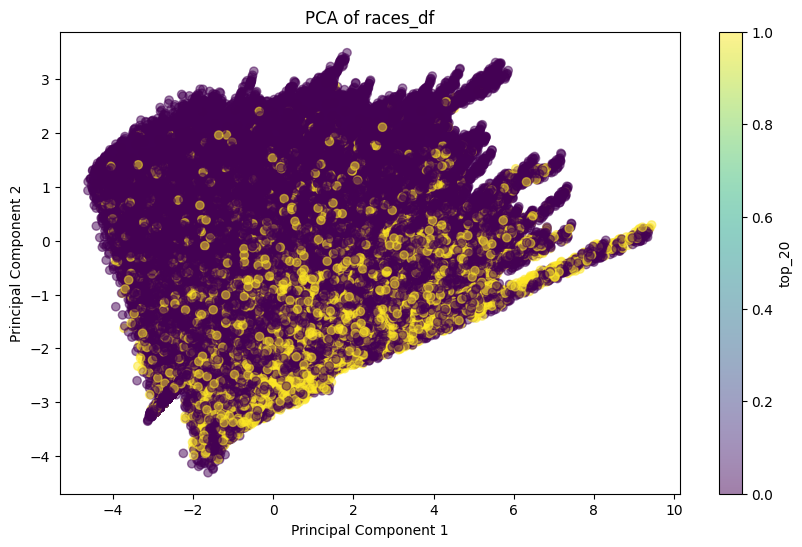

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# select data and scale it
features = races_df.drop(columns=['top_20'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

#  Create a DataFrame with the principal components and plot them
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['top_20'] = races_df['top_20']

plt.figure(figsize=(10,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['top_20'], cmap='viridis', alpha=0.5)
plt.colorbar(label='top_20')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of races_df')
plt.show()


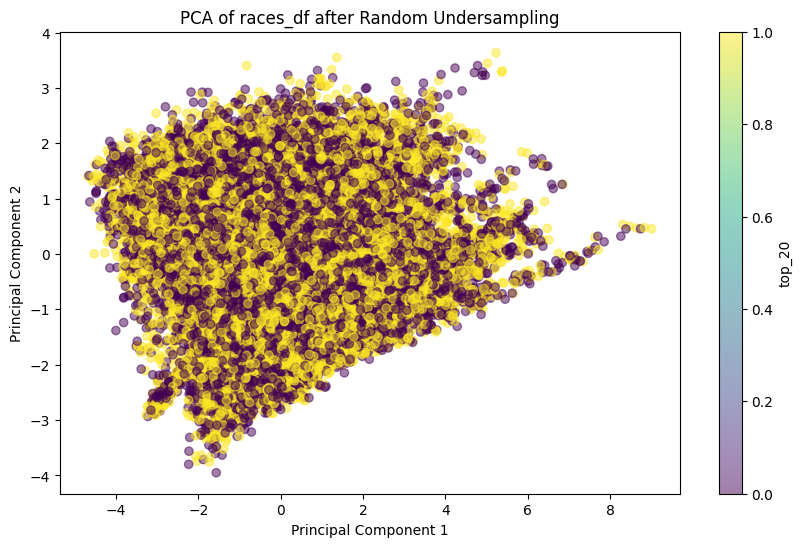

In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features and target
X = races_df.drop(columns=['top_20'])
y = races_df['top_20']

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# Combine the resampled features and target into a new DataFrame
races_resampled_df = pd.DataFrame(X_res, columns=X.columns)
races_resampled_df['top_20'] = y_res

# select data and scale it
features = races_resampled_df.drop(columns=['top_20'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components and plot them
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['top_20'] = races_resampled_df['top_20']

plt.figure(figsize=(10,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['top_20'], cmap='viridis', alpha=0.5)
plt.colorbar(label='top_20')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of races_df after Random Undersampling')
plt.show()


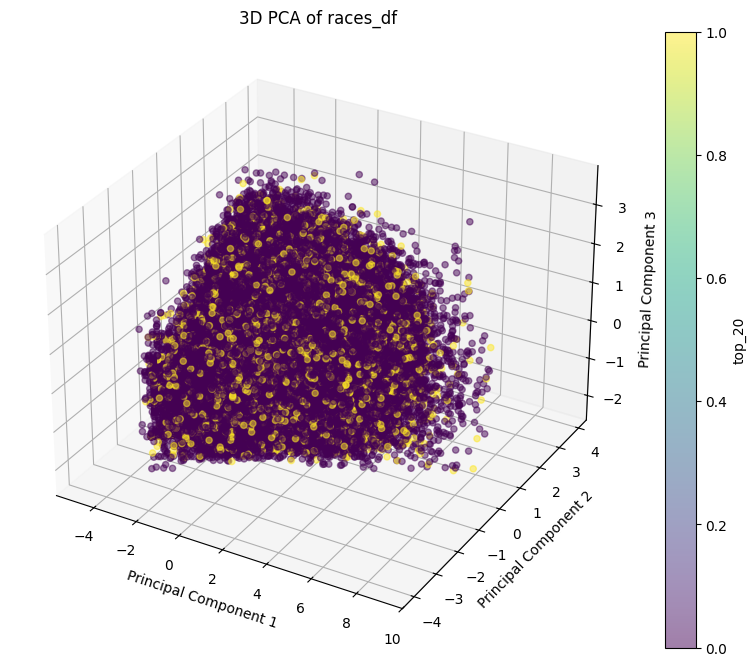

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components and plot them
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['top_20'] = races_df['top_20']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['top_20'], cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='top_20')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of races_df')
plt.show()


Data not seems to be separated either with undersamplig or in 2 and in 3 dimensions

## Mutual Information

Let's use Mutual Information to try to find some correlation between our features and the target one

In [8]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# compute the mutual information
mi = mutual_info_classif(races_df.drop(columns=["top_20"]), races_df["top_20"], discrete_features="auto")

# create a DataFrame with the mutual information and plot it
mi_df = pd.DataFrame({
    'Feature': races_df.drop(columns=["top_20"]).columns,  # Nomi delle feature (escludendo top_20)
    'Mutual Information': mi
})
mi_df.sort_values(by='Mutual Information', ascending=False, inplace=True)

print(mi_df)

                 Feature  Mutual Information
6         top_20_entropy            0.043944
4  avg_relative_position            0.030827
5       position_entropy            0.010781
2          cyclist_level            0.007054
1            cyclist_age            0.006133
3     cyclist_experience            0.001928
0            climb_total            0.000000


The analysis of Mutual Information (MI) reveals that the dataset features have low predictive power for distinguishing between cyclists in the top 20 and others. Most features show minimal or no correlation with the target, and their distributions overlap significantly between classes, indicating limited discriminative capacity.

## Random Classifier

Here, we randomly assign values to top_20 and then test the best model to determine if it outperforms the original one.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score,  confusion_matrix, get_scorer, make_scorer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
from imblearn.combine import SMOTETomek

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division

In [11]:
train_labels = train_labels.sample(frac=1, random_state=42).reset_index(drop=True)
test_labels = test_labels.sample(frac=1, random_state=42).reset_index(drop=True)

numeric_transformer = StandardScaler()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, train_data.columns),
    ])

resampling = SMOTETomek(sampling_strategy=0.9, random_state=42)
clf = LGBMClassifier(boosting_type='rf', is_unbalance=True, importance_type='gain', verbose=-1, random_state=0, n_jobs=1)

# Create the model pipeline
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("resampling", resampling),
        ("clf", clf)]
)

# Define the hyperparameter grid
params = {
        'clf__boosting_type': ['gbdt'],
        'clf__n_estimators': [50, 60, 70, 80, 90, 100, 120, 150, 170],
        'clf__learning_rate': [0.0001, 0.0005, 0.001, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'clf__max_depth': [2, 3, 4, 5],
        'clf__reg_lambda': [0.0001, 0.005, 0.001, 0.005, 0.01, 0.1, 0.3, 0.5, 0.7],
        'clf__reg_alpha': [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7],
        'clf__max_bins': [4, 8, 16, 32, 64, 128, 255],
        'clf__min_child_samples': [5, 10, 15, 20],
        'clf__is_unbalance': [False],
        'clf__importance_type': ['gain'],
        'clf__verbose': [-1],
        'clf__random_state': [0],
        'clf__n_jobs': [1]
}


# Define the scoring functions
scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

# Perform randomized search cross-validation
rscv = RandomizedSearchCV(
    model, 
    param_distributions=params, 
    scoring=scoring,
    n_iter=30, 
    cv=5,   # already stratified!
    verbose=1, 
    n_jobs=-1, 
    random_state=42, 
    refit="f1"
    ) 

rscv.fit(train_data, train_labels.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy',
       'top_20'],
      dtype='object'))])),
                                             ('resampling',
                                              SMOTETomek(random_state=42,
                                                         sampling_strategy=0.9)),
                                             (...
                            'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                            'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

### Validation scores:

In [12]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.3099, Std: 0.0076
Specificity - Mean: 0.6956, Std: 0.0053
Accuracy - Mean: 0.6444, Std: 0.0040
Precision - Mean: 0.1349, Std: 0.0020
Recall - Mean: 0.3099, Std: 0.0076
Roc_auc - Mean: 0.5028, Std: 0.0037
F1 - Mean: 0.1879, Std: 0.0031


In [13]:
# extract the results of the randomized search and best model idx
cv_results = rscv.cv_results_
best_index = rscv.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.3099, Std: 0.0076
Specificity - Mean: 0.6956, Std: 0.0053
Accuracy - Mean: 0.6444, Std: 0.0040
Precision - Mean: 0.1349, Std: 0.0020
Recall - Mean: 0.3099, Std: 0.0076
Roc_auc - Mean: 0.5028, Std: 0.0037
F1 - Mean: 0.1879, Std: 0.0031


### Test scores:

Accuracy: 0.664
Recall: 0.28
Precision: 0.151
Sensitivity: 0.28
Specificity: 0.73
F1 Score: 0.196
ROC AUC Score: 0.505


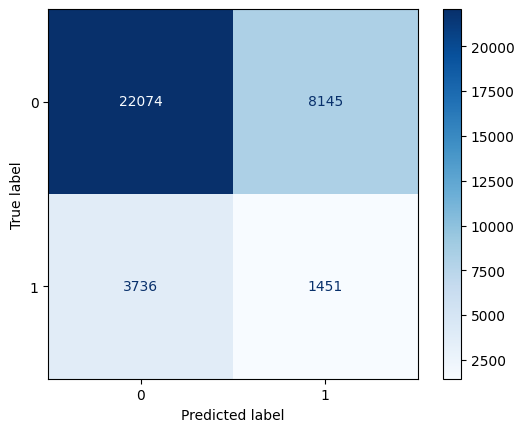

In [14]:
# Predict on the test data
test_predictions = rscv.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [15]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.73      0.79     30219
           1       0.15      0.28      0.20      5187

    accuracy                           0.66     35406
   macro avg       0.50      0.51      0.49     35406
weighted avg       0.75      0.66      0.70     35406



The best model outperforms the random classifier in accuracy, specificity, and AUC, but still struggles with sensitivity and precision. However, the random classifier is not much worse, suggesting that the main issue lies in the imbalanced dataset and the difficulty in separating the classes. This indicates that the challenges stem more from the dataset structure than the models themselves given that all the models were tried with different resempler, different class weights...